In [1]:
!pip install mutagen
# handle audio metadataimport 

In [2]:
pip install mutagen numpy pandas torch torchaudio librosa matplotlib tqdm

Note: you may need to restart the kernel to use updated packages.


In [3]:
import numpy as np
import pandas as pd
import os
import librosa
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from IPython.display import Audio
import glob
import concurrent.futures
from torch.utils.data import Dataset, DataLoader
import torchaudio
import torch
from torch import nn

In [4]:
train_audio_files_path = 'LA/LA/ASVspoof2019_LA_train/flac/'
train_labels_path = 'LA/LA/ASVspoof2019_LA_cm_protocols/ASVspoof2019.LA.cm.train.trn.txt.txt'

In [5]:
from mutagen.flac import FLAC

In [6]:
def process_flac_file(flac_file):
    try:
        audio = FLAC(flac_file)
        duration = audio.info.length
        sample_rate = audio.info.sample_rate
        return flac_file, duration, sample_rate
    except Exception as e:
        print(f"Error processing {flac_file}: {e}")
        return flac_file, None, None

def process_flac_files_in_batch(flac_files):
    durs = []
    srs = []
    with concurrent.futures.ThreadPoolExecutor() as executor:
        futures = [executor.submit(process_flac_file, flac_file) for flac_file in flac_files]
        for future in concurrent.futures.as_completed(futures):
            result = future.result()
            durs.append(result[1])
            srs.append(result[2])
    return durs, srs

def durations_flac(flac_files_directory):
    flac_files = glob.glob(os.path.join(flac_files_directory, "*.flac"))

    batch_size = 1
    file_batches = [flac_files[i:i + batch_size] for i in range(0, len(flac_files), batch_size)]

    durs = []
    srs = []
    for batch in tqdm(file_batches):
        dur, sr = process_flac_files_in_batch(batch)
        durs.extend(dur)
        srs.extend(sr)
    return durs, srs

In [7]:
durs,srs = durations_flac(train_audio_files_path)

  0%|          | 0/4 [00:00<?, ?it/s]

In [8]:
set(srs)

{16000}

(array([1., 1., 0., 0., 0., 0., 0., 0., 0., 2.]),
 array([2.500375, 3.105775, 3.711175, 4.316575, 4.921975, 5.527375,
        6.132775, 6.738175, 7.343575, 7.948975, 8.554375]),
 <BarContainer object of 10 artists>)

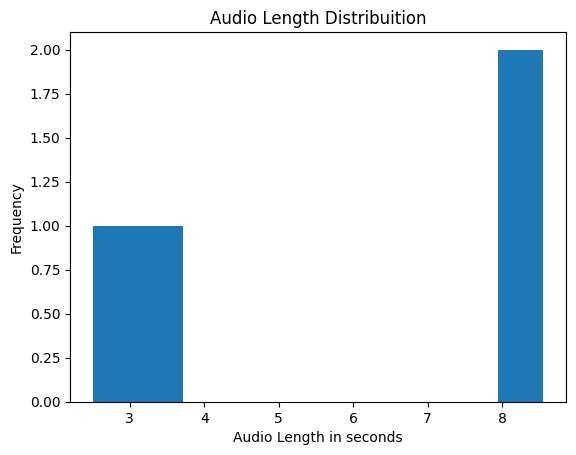

In [9]:
plt.xlabel("Audio Length in seconds")
plt.ylabel("Frequency")
plt.title("Audio Length Distribuition")
plt.hist(durs)

In [10]:
def audio_eda(audio_path):
    samples, sampling_rate = librosa.load(audio_path, sr = None)
    
    
    # plotting waveform
    plt.figure(figsize=(14, 5))
    librosa.display.waveshow(samples)
    plt.title('Waveform')
    display(Audio(samples, rate = sampling_rate))
    
    # Compute the spectrogram
    spectrogram = librosa.stft(samples)
    spectrogram_db = librosa.amplitude_to_db(abs(spectrogram))

    # Visualize the spectrogram
    plt.figure(figsize=(14, 5))
    librosa.display.specshow(spectrogram_db, sr=sampling_rate, x_axis='time', y_axis='log')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Spectrogram (dB)')

    # Compute the mel spectrogram


    # Visualize the mel spectrogram
    S = librosa.feature.melspectrogram(y=samples, sr=sampling_rate)

    # Visualize mel spectrogram
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(librosa.power_to_db(S, ref=np.max), y_axis='mel', fmax=8000, x_axis='time')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Mel spectrogram')
    plt.tight_layout()

    
    plt.show()

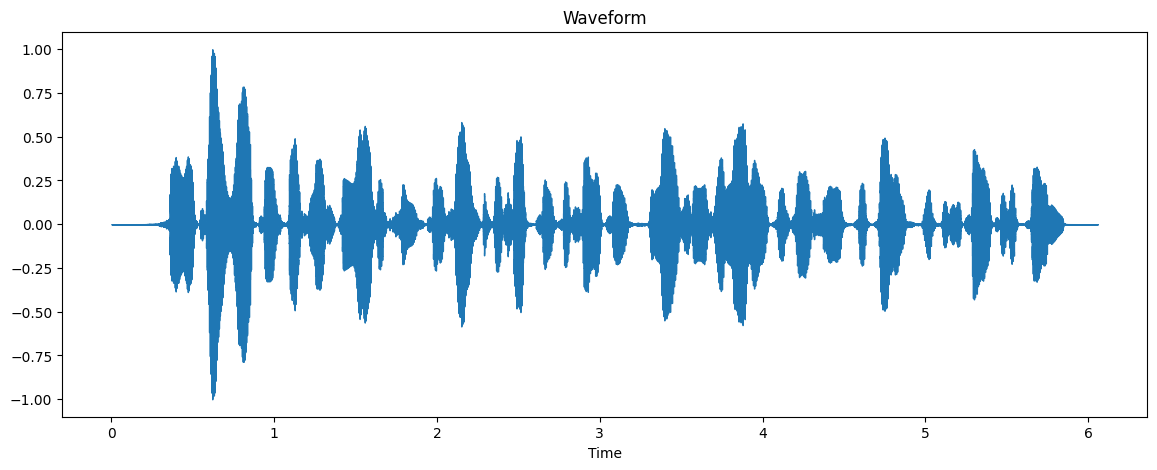

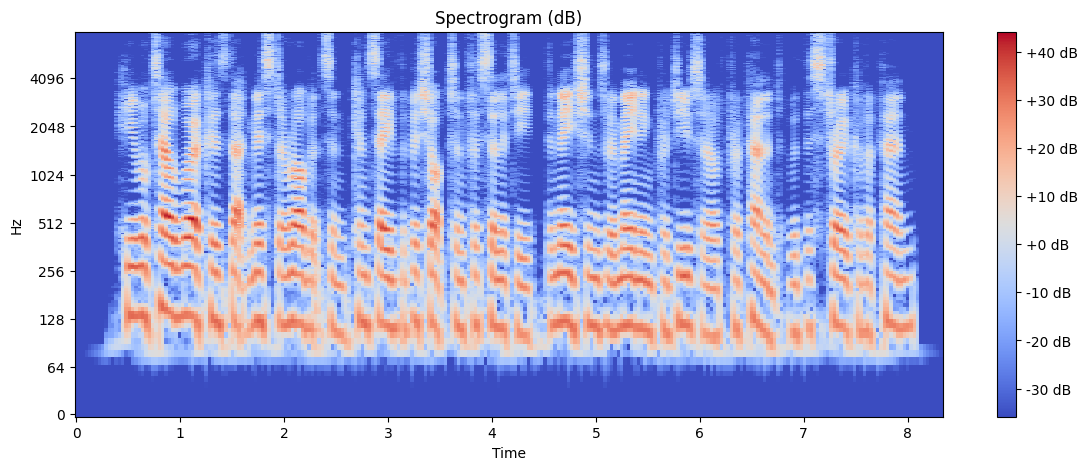

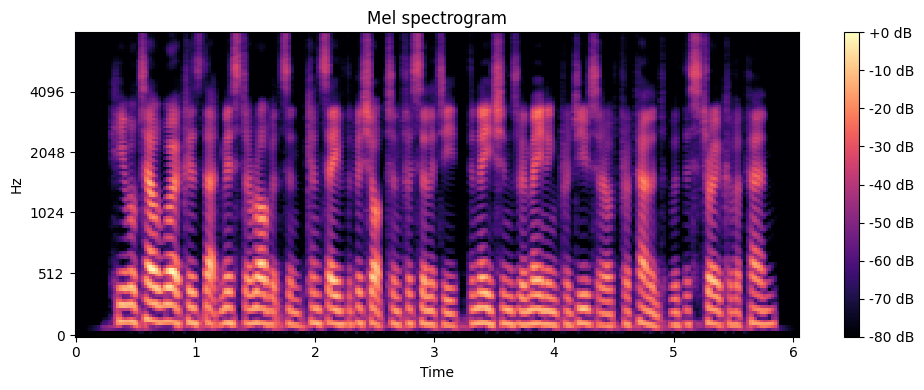

In [11]:
s = audio_eda("LA/LA/ASVspoof2019_LA_train/flac/LA_T_1025067.flac")

In [12]:
def readtxtfile(path):
    with open(path, 'r') as file:
        text = file.read().splitlines()
        return text
    
def getlabels(path):
    text = readtxtfile(path)
    filename2label = {}
    for item in tqdm(text):
        key = item.split(' ')[1]
        value = item.split(' ')[-1]
        filename2label[key] = value
        
    return filename2label

In [13]:
filename2label = getlabels(train_labels_path)

  0%|          | 0/4 [00:00<?, ?it/s]

3 1


(array([3., 0., 0., 0., 0., 0., 0., 0., 0., 1.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

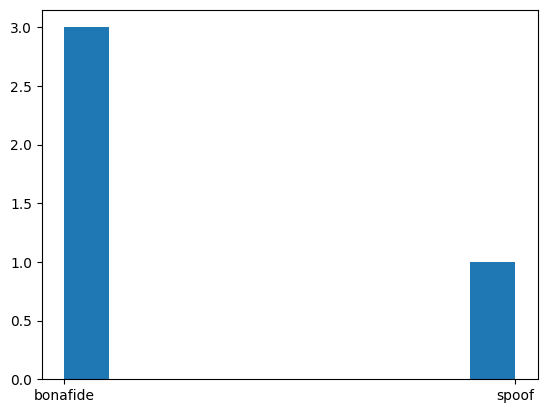

In [14]:
l = list(filename2label.values())
print(l.count('bonafide'), l.count('spoof'))
plt.hist(l)

In [15]:
val_audio_files_path = 'LA/LA/ASVspoof2019_LA_eval/flac/'
val_labels_path = 'LA/LA/ASVspoof2019_LA_cm_protocols/ASVspoof2019.LA.cm.eval.trl.txt.txt'
val_filename2label = getlabels(val_labels_path)

  0%|          | 0/6 [00:00<?, ?it/s]

2 4


(array([4., 0., 0., 0., 0., 0., 0., 0., 0., 2.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

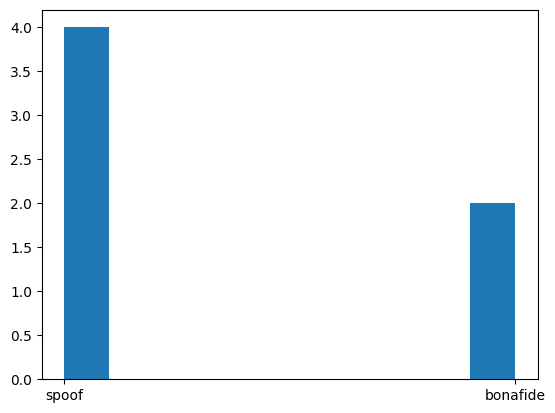

In [16]:
l = list(val_filename2label.values())
print(l.count('bonafide'), l.count('spoof'))
plt.hist(l)

In [17]:
import os
import torchaudio
import torch

class ASVSpoof(torch.utils.data.Dataset):
    def __init__(self, audio_dir_path, num_samples, filename2label, transforms=None, specific_files=None):
        super().__init__()
        self.audio_dir_path = audio_dir_path
        self.num_samples = num_samples
        self.audio_file_names = self.get_audio_file_names(filename2label)
        self.labels, self.label2id, self.id2label = self.get_labels(filename2label)

        # Filter the audio files based on specific files if provided
        if specific_files:
            self.audio_file_names = [f"{file}.flac" for file in specific_files if f"{file}.flac" in self.audio_file_names]
            self.labels = [self.labels[i] for i in range(len(self.labels)) if self.audio_file_names[i] in [f"{file}.flac" for file in specific_files]]

        # Ensure audio_file_names and labels have the same length
        if len(self.audio_file_names) != len(self.labels):
            raise ValueError("The number of audio files does not match the number of labels.")

        # Initialize transforms
        self.transforms = transforms

    def __getitem__(self, index):
        audio_file = os.path.join(self.audio_dir_path, self.audio_file_names[index])
        try:
            signal, sr = torchaudio.load(audio_file)
            signal = self.mix_down_if_necessary(signal)
            signal = self.cut_if_necessary(signal)
            signal = self.right_pad_if_necessary(signal)
            if self.transforms:
                signal = self.transforms(signal)  # Apply transforms if provided
            label = self.labels[index]
            return signal, label
        except Exception as e:
            print(f"Error loading {audio_file}: {e}. Skipping this file.")
            raise  # Raise an exception to indicate this entry is invalid

    def __len__(self):
        return len(self.labels)

    def get_audio_file_names(self, filename2label):
        audio_file_names = list(filename2label.keys())
        audio_file_names = [name + '.flac' for name in audio_file_names]  # adding extension
        return audio_file_names

    def get_labels(self, filename2label):
        labels = list(filename2label.values())
        id2label = {idx: label for idx, label in enumerate(set(labels))}
        label2id = {label: idx for idx, label in enumerate(set(labels))}
        labels = [label2id[label] for label in labels]
        return labels, label2id, id2label

    def mix_down_if_necessary(self, signal):  # converting from stereo to mono
        if signal.shape[0] > 1: 
            signal = torch.mean(signal, dim=0, keepdims=True)
        return signal

    def cut_if_necessary(self, signal):
        if signal.shape[1] > self.num_samples:
            signal = signal[:, :self.num_samples]
        return signal

    def right_pad_if_necessary(self, signal):
        length = signal.shape[1]
        if self.num_samples > length:
            pad_last_dim = (0, self.num_samples - length)
            signal = torch.nn.functional.pad(signal, pad_last_dim)
        return signal

In [18]:
mel_spectogram = torchaudio.transforms.MelSpectrogram(
    sample_rate = 16000,
    n_fft = 1024,
    hop_length = 512,
    n_mels = 64
)
num_samples = 6 * 16000 # IMPORTANT!!
train_dataset = ASVSpoof(train_audio_files_path, num_samples, filename2label, mel_spectogram)
val_dataset = ASVSpoof(val_audio_files_path, num_samples, val_filename2label, mel_spectogram)

In [19]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels = 1,
                out_channels = 16,
                kernel_size = 3,
                stride = 1,
                padding = 2
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2)
        )
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(
                in_channels = 16,
                out_channels = 32,
                kernel_size = 3,
                stride = 1,
                padding = 2
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2)
        )
        
        self.conv3 = nn.Sequential(
            nn.Conv2d(
                in_channels = 32,
                out_channels = 64,
                kernel_size = 3,
                stride = 1,
                padding = 2
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2)
        )
        
        self.conv4 = nn.Sequential(
            nn.Conv2d(
                in_channels = 64,
                out_channels = 128,
                kernel_size = 3,
                stride = 1,
                padding = 2
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2)
        )
        
        self.flatten = nn.Flatten()
        self.linear = nn.Linear(8320 , 1)
        self.softmax = nn.Sigmoid()
        
    def forward(self, inputs):
        x = self.conv1(inputs)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.flatten(x)
#         print(x.shape)
        x = self.linear(x)
        x = self.softmax(x)
#         print(x.shape)
        return x

In [20]:
device = ('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
num_epochs = 1
criterion = nn.BCELoss()
model = Model().to(device)
optimizer = torch.optim.Adam(model.parameters())

cpu


In [21]:
train_loader = torch.utils.data.DataLoader(train_dataset, shuffle = True, batch_size = 1)
val_loader = torch.utils.data.DataLoader(val_dataset, shuffle = True, batch_size = 2)

In [22]:
# List of specific audio files for training
specific_train_audio_files = [
    'LA_T_1000137',
    'LA_T_1007663',
    'LA_T_1025067',
    'LA_T_1040732'
]


# Create the training dataset with specific audio files
train_dataset = ASVSpoof(
    train_audio_files_path, 
    num_samples, 
    filename2label, 
    mel_spectogram, 
    specific_files=specific_train_audio_files  # Pass the specific training files here
)

# Initialize the DataLoader for training
train_loader = torch.utils.data.DataLoader(train_dataset, shuffle=True, batch_size=1)

# Training Loop
train_loss = 0.0
for epoch in range(num_epochs):
    loop = tqdm(enumerate(train_loader), total=len(train_loader))
    for batch_idx, (images, labels) in loop:
        loop.set_description(f'Epoch {epoch + 1} / {num_epochs}')
        
        try:
            # Forward pass
            model.train()
            images = images.to(device)
            labels = labels.to(device).reshape(-1, 1)
            labels = labels.type(torch.FloatTensor)  # use torch.FloatTensor if on CPU
            
            optimizer.zero_grad()
            outputs = model(images)
            
            loss = criterion(outputs, labels)
            train_loss += loss.item()
            
            # Backward pass
            loss.backward()
            optimizer.step()
            
            loop.set_postfix(Training_loss=loss.item())
        except Exception as e:
            print(f"Error during training at batch {batch_idx}: {e}. Skipping this batch.")
            continue  # Skip to the next batch if an error occurs

    print(f'Epoch: {epoch + 1} Training loss: {train_loss / len(train_loader)}')


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 1 Training loss: 25.137351840734482


In [23]:
from sklearn.metrics import roc_auc_score, roc_curve

In [24]:
# List of specific audio files for validation
specific_val_audio_files = [
    'LA_E_1000147',
    'LA_E_1000273',
    'LA_E_1000791',
    'LA_E_1001320',
    'LA_E_1001964',
    'LA_E_1002802'
]

# Create the validation dataset with specific audio files
val_dataset = ASVSpoof(
    val_audio_files_path, 
    num_samples, 
    val_filename2label, 
    mel_spectogram, 
    specific_files=specific_val_audio_files  # Pass the specific validation files here
)

# Initialize the DataLoader for validation
val_loader = torch.utils.data.DataLoader(val_dataset, shuffle=True, batch_size=2)

# Validation every epoch
model.eval()
val_loss = 0.0
with torch.no_grad():
    val_loop = tqdm(enumerate(val_loader), total=len(val_loader))
    for val_batch_idx, (val_images, val_labels) in val_loop:
        val_images = val_images.to(device)
        val_labels = val_labels.to(device).reshape(-1, 1)
        val_labels = val_labels.type(torch.FloatTensor)  # use torch.FloatTensor if on CPU

        val_outputs = model(val_images)
        curr_val_loss = criterion(val_outputs, val_labels)
        val_loss += curr_val_loss.item()
        val_loop.set_postfix(validation_loss=curr_val_loss.item())

print(f'Epoch: {epoch + 1} Training loss: {train_loss / len(train_loader)}')


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 1 Training loss: 25.137351840734482


In [25]:
from sklearn.metrics import roc_auc_score, roc_curve

In [26]:
model.eval()
outputs = []
labels = []
with torch.no_grad():
    val_loop = tqdm(enumerate(val_loader), total = len(val_loader))
    for val_batch_idx, (val_images, val_labels) in val_loop:
        val_images = val_images.to(device)
        val_labels = val_labels.to(device).reshape(-1, 1)
        val_labels = val_labels.type(torch.FloatTensor) #use torch.FloatTensor if on cpu

        val_outputs = model(val_images)
        outputs.append(val_outputs.cpu().numpy())
        labels.append(val_labels.cpu().numpy())
        curr_val_loss = criterion(val_outputs, val_labels)
        val_loss += curr_val_loss.item()
        val_loop.set_postfix(validation_loss = curr_val_loss.item())

  0%|          | 0/3 [00:00<?, ?it/s]

In [27]:
labels = np.concatenate(labels)
outputs = np.concatenate(outputs)
print(labels.shape, outputs.shape)

(6, 1) (6, 1)


In [28]:
labels[:10]

array([[1.],
       [1.],
       [1.],
       [0.],
       [0.],
       [1.]], dtype=float32)

In [29]:
outputs.max()

0.0